# Visualizing yule and exponential coalescent trees using BALTIC

Maximum clade credability tree was dervied from BEAST output using Tree Annotator. BEAST was run using Yule speciation process and strict molecular clock. Location was input as a continuous bivariate trait that represented latitude and longitude and was modeled with gamma RRW. Both the location and clone was infered for all ancestors. 

In [32]:
import baltic as bt
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
%matplotlib inline 
import operator
import copy
import numpy as np
import pandas as pd
import math
from statsmodels.nonparametric.api import KernelReg
from math import log
import scipy
import seaborn as sns


## Load tree into Baltic structure and map clone onto inferred states

In [33]:
#make dictionary to define clones as specific states as defined in Ling et all. I made the choice here to weight shared variation over penalizing lack of shared variation
state_dict = {}
ph = 2 #2's will replace 0s because I define clone by presense of mutation and not absence. 
state_dict['zeta'] = [1,1] + [ph] * 33
state_dict['eta'] = [ph,ph] +[1] + [ph] * 32
state_dict['alpha'] = [ph]*5 + [1,1,1,1] + [ph]*26
state_dict['gamma'] = [ph]*9 + [1]*2 + [ph]*24
state_dict['epsilon'] = [ph]*15 + [1,1] +[ph]*18
state_dict['delta'] = [ph]*21 + [1]*4 + [ph]*10
state_dict['beta'] = [ph]*29 + [1] + [ph]*5

#make color dictionary to connect each clone with a specific color close to those observed in Ling et al
colors = {'beta':'lightgreen','gamma': 'gold', 'alpha': 'darkturquoise', 'epsilon':'salmon', 'zeta': 'orange', 'eta':'magenta','delta':
          'blue','mu':'green','omega':'silver','?':"silver"}

In [79]:
'''
load in tree using baltic. This converts tree string into tree object with node and leaf objects that each have their own parent 
and children. traverse_tree() and treeDraw() are key parts of assigning x and y coordinates to plot the tree within loadNexus()
'''
expcol_tree = bt.loadNexus('expcol_spatial_dash_MLE.mcc', absoluteTime=False) #tree with locations + clones as infered traits
yule_tree = bt.loadNexus('yule_spatial_dash_MLE.mcc', absoluteTime=False) #tree with locations + clones as infered traits
trees = [expcol_tree,yule_tree]
titles = ['Exponential Coalescent', 'Yule Speciation Process']


In [80]:
#use the clone dictionary to map defined clones onto infered states
##mapping clones on,to inferred state values


for t in range(len(trees)):
    for k in trees[t].Objects:
        state = list(k.traits['alleles_fasta_meta'])
        match = False
        bestcount = 0
        g = 'omega'
        for key in state_dict:
            index = 0
            countlist = []
            count = 0
            for i in state_dict[key]:
                if str(i) == state[index]:
                    count += 1
                    if count >= bestcount: #take clone with most shared mutations
                        bestcount = count
                        g = key
                index += 1
        k.traits['clone'] = g
        if isinstance(k, bt.leaf) and len(k.name.split('|')) > 1: #if you want to decide leaf color based on assigned clones
            k.traits['clone'] = k.name.split('|')[-3]
#     for k in trees[t].Objects:
#         if isinstance(k,bt.node):
#             if any([child.traits['clone'] == k.parent.traits['clone'] for child in k.children]):
#                 k.traits['clone'] = k.parent.traits['clone']


## Draw rooted trees

In [36]:
fig1,ax = plt.subplots(1,2,figsize=(20,20),facecolor='w')
#ax = fig.add_subplot(3, 1, 1)

'''
Subplots can help you make, well, subplots. You can specify things like number of plots, rows/columns, etc.
We don't care about that here because we just need one. 
fig = figure
ax = axis
'''

'''
Gytis's example baltic code lives at https://github.com/blab/baltic/blob/master/austechia.ipynb
'''

branchWidth=2 ## default branch width

cmap=mpl.cm.viridis ## colors! https://github.com/blab/wiki/wiki/Colors
for t in range(len(trees)):
    for k in trees[t].Objects: ## iterate over objects in tree
        x=k.x ## or from x position determined earlier
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if k.traits['clone'] != 'nan': #decide color based on mapped clones
            c = colors[k.traits['clone']] if k.traits.has_key('clone') else cmap(1.0)[0]
        else: c = 'silver'


        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...

            s=30 ## tip size can be fixed

            ax[t].scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax[t].scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            ax[t].plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth, color= c ,ls='-',zorder=9)
)
        ax[t].plot([xp,x],[y,y],lw=branchWidth,color= c ,ls='-',zorder=9)


    ax[t].set_ylim(-5,trees[t].ySpan+5)
    ax[t].set_title('%s'%titles[t])
    han_list = []

    for key in colors:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key, markeredgecolor='k',markersize = 8)
        han_list.append(marker)

    ax[t].legend(handles = han_list,markerfirst = True,title = 'Clone')

ax[1].legend(handles = han_list,markerfirst = True,title = 'Clone')


plt.savefig('figures/yule_expol_rootedTree.png')
plt.show()

## Draw unrooted trees

In [66]:
fig,ax = plt.subplots(1,2,figsize=(20,10),facecolor='w')
for t in range(len(trees)):
    trees[t].uncollapseSubtree() ## uncollapse
    trees[t].drawUnrooted() ## draw tree as unrooted

    for k in trees[t].Objects: ## iterate over objects in tree
        x=k.x ## or from x position determined earlier
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.x ## get x position of current object's parent
        yp=k.parent.y

        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if k.traits['clone'] != 'nan':
            c = colors[k.traits['clone']] if k.traits.has_key('clone') else cmap(1.0)[0]
        else: c = 'silver' 
        #cmap=[mpl.cm.Reds if k.traits['type']=='HongKong' else mpl.cm.Blues][0] ## pick colour map based on trait
        #c=cmap(k.height/mtt.treeHeight) ## colour with colour map based on height of branch
        if k.branchType=='leaf': ## if leaf...
            s=30 ## tip size can be fixed
           

            ax[t].scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax[t].scatter(x,y,s=s*2,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

        ax[t].plot([xp,x],[yp,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
    ax[t].set_title('%s'%titles[t],size = 20)

    ax[t].spines['top'].set_visible(False) ## no axes
    ax[t].spines['right'].set_visible(False)
    ax[t].spines['left'].set_visible(False)
    ax[t].spines['bottom'].set_visible(False)

    ax[t].tick_params(axis='x',size=0) ## no labels
    ax[t].tick_params(axis='y',size=0)
    ax[t].set_xticklabels([])
    ax[t].set_yticklabels([])
    ax[1].legend(handles = han_list,markerfirst = True,title = 'Clone')
    plt.savefig('figures/yule_expcol_unrootedTree.png')


## Spatial representation of tumor evolution

In [38]:
fig,ax = plt.subplots(1,2,figsize=(20,10),facecolor='w')


for t in range(len(trees)):

    for k in trees[t].Objects: ## iterate over objects in tree

        x = k.traits['location1']
        y = k.traits['location2']
        if  k.parent.traits.has_key('location1'):
            xp = k.parent.traits['location1']
        else:
            xp  = x
        if  k.parent.traits.has_key('location2'):
            yp = k.parent.traits['location2']
        else:
            yp = y

        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
            
        if xp == None:
            xp = x

        if k.traits['clone'] != 'nan':
            c = colors[k.traits['clone']] if k.traits.has_key('clone') else cmap(1.0)[0]
        else: c = 'silver' 

        if k.branchType=='leaf' or isinstance(k,bt.leaf): ## if leaf...
            s=45 ## tip size can be fixed

            ax[t].scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax[t].scatter(x,y,s=s*2,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

        ax[t].plot([xp,x],[yp,y],lw=branchWidth,color=c,ls='-',zorder=9)

    han_list = []


    for key in colors:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key, markeredgecolor='k',markersize = 8)
        han_list.append(marker)

    ax[t].legend(handles = han_list,markerfirst = True,title = 'Clone')
    ax[t].set_xlabel('X coordinate (mm)')
    ax[t].set_ylabel('Y coordiante (mm)')
    ax[t].set_title('%s'%titles[t])

plt.savefig('figures/yule_expcol_2dspaceTree.png')
plt.show()

## Spatial growth through time

In [39]:
'''
this function is to take time slices of tree and return a new set of leaves.
for a function that will return the full sliced tree see timeslice_full()
'''
def timeslice(tree, time): ## function to slice tree at time time
    newleaves = []
    for k in tree.Objects: ## loop through all nodes and leaves of tree
        g = k.traits['clone'] # store clone value
        if k.x <= time:
            lx = k.traits['location1']
            ly = k.traits['location2']
            if isinstance(k,bt.leaf) or k.x == time: 
                if  k.parent.traits.has_key('location1'):
                    pxcoord = k.parent.traits['location1']
                else:
                    pxcoord  = lx
                if  k.parent.traits.has_key('location2'):
                    pycoord = k.parent.traits['location2']
                else:
                    pycoord = ly
                nl = {'xcoord':lx,'ycoord':ly,'clone':g,'pxcoord':pxcoord,'pycoord':pycoord, 'px': k.parent.x,"x":time}
                newleaves.append(nl)
            elif isinstance(k,bt.node) or k.branchType=='node':
                for c in k.children:
                    if c.x > time: 
                        lcx = c.traits['location1']
                        lcy = c.traits['location2']
                        m = (lcy - ly)/(lcx - lx)
                        deltaX = (time - k.x)/(c.x - k.x) * (lcx - lx)
                        newX = lx + deltaX
                        newY = ly + deltaX * m
                        nl = {'xcoord':newX,'ycoord':newY,'clone':g,'pxcoord':lx,'pycoord':ly, 'px': k.x, "x": time}
                        newleaves.append(nl)
    return newleaves

In [40]:
for tree in trees:
    tree.drawTree()

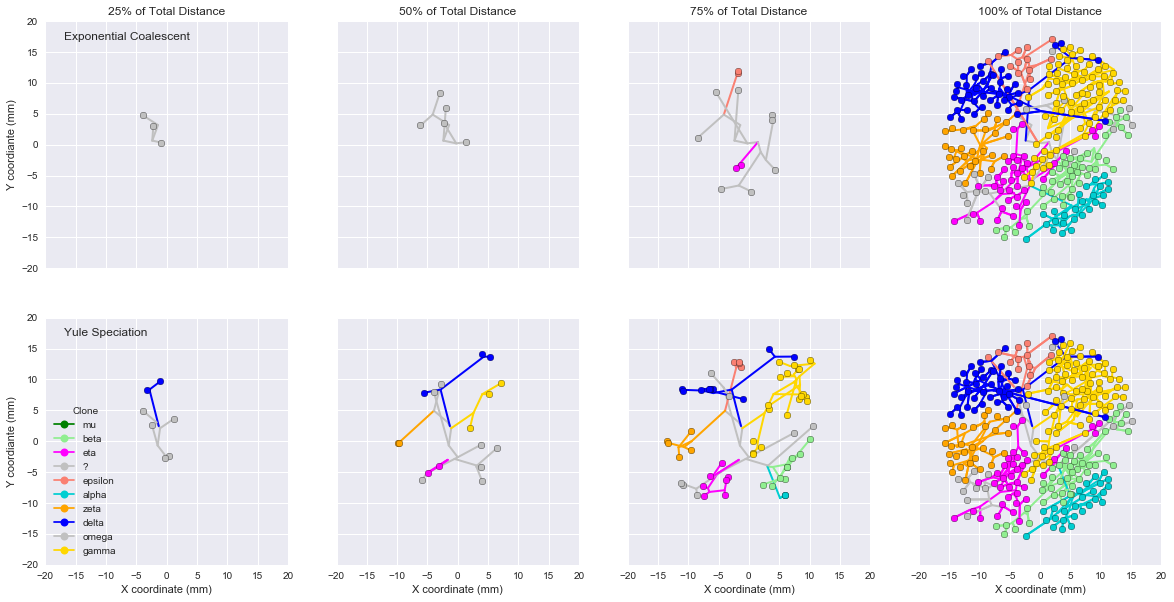

In [41]:
timep = ['25%', '50%', '75%','100%']

fig,ax = plt.subplots(2,4,figsize=(20,10),sharex='col', sharey='row')

for i in range(len(trees)):
    times = [trees[i].treeHeight * x / 4 for x in range(1,5)]
    for j in range(4):
        time = times[j]
        newleaves = timeslice(trees[i],time)
        nodslice = []
        for k in trees[i].Objects: ## iterate over objects in tree
            if k.x < time:

                g = k.traits['clone']
                x = k.traits['location1']
                y = k.traits['location2']
                if  k.parent.traits.has_key('location1'):
                    xp = k.parent.traits['location1']
                else:
                    xp  = x
                if  k.parent.traits.has_key('location2'):
                    yp = k.parent.traits['location2']
                else:
                    yp = y

                if x==None: ## matplotlib won't plot Nones, like root
                    x=0.0
                if xp==None:
                    xp=x

                if k.traits.has_key('clone'):
                    c = colors[k.traits['clone']]
                else: 
                    c = 'silver' 

                nn = {'xcoord':x,'ycoord':y,'clone':g,'pxcoord':xp,'pycoord':yp, 'px': k.parent.x,"x":k.x} 
                nodslice.append(nn)

                ax[i,j].plot([xp,x],[yp,y],lw=branchWidth,color=c,ls='-',zorder=9)


        for leaf in newleaves:
            if leaf['x'] == time:
                s = 45
                x = leaf['xcoord']
                y = leaf['ycoord']
                xp = leaf['pxcoord']
                yp = leaf['pycoord']
                if leaf.has_key('clone'):
                    c = colors[leaf['clone']]
                else: 
                    c = 'silver'


                ax[i,j].scatter(x,y,s=s,facecolor = c, edgecolor = 'k',zorder = 10)
                ax[i,j].plot([xp,x],[yp,y], lw=branchWidth,color = c, ls='-',zorder = 9)

        ax[1,j].set_xlabel('X coordinate (mm)')
        ax[i,0].set_ylabel('Y coordiante (mm)')
        ax[i,j].set_xlim(-20,20)
        ax[i,j].set_ylim(-20,20)
        ax[0,j].set_title('%s of Total Distance' % timep[j])
han_list = []

for key in colors:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key, markeredgecolor='k',markersize = 8)
    han_list.append(marker)

ax[1,0].legend(handles = han_list, markerfirst = True, title = 'Clone', loc='lower left')
ax[0,0].text(-17,17,'Exponential Coalescent', size = 12)
ax[1,0].text(-17,17,'Yule Speciation',size = 12)


plt.savefig('figures/yule_expcol_timeslice.png')
plt.show()


## Local branching index 
The local branching index is a indicator of clone growth in its immediate history. 

In [42]:
def timeslice_full(tree, time, lbi = False): ## function to slice tree at time time
    '''
    This function returns a full tree that exists before the time specified
    '''
    newtree=copy.deepcopy(tree)
    newleaves = []
    newnodes = []
    newobjects = []
    newtree.preorder_node = sorted(newtree.Objects, key = operator.attrgetter('height'), reverse = False)
    for k in newtree.preorder_node: ## loop through all nodes and leaves of tree
        if k.x <= time:
            lx = k.traits['location1']
            ly = k.traits['location2']
            if isinstance(k,bt.leaf) or k.branchType =='leaf' or k.x == time: 
                newleaf = bt.leaf()
                newleaf.traits = k.traits
                newleaf.parent = k.parent
                newleaf.x = k.x
                newleaf.y = k.y
                newleaf.height = k.height
                newleaf.length = k.length
                if lbi == True:
                    newleaf.lb = k.lb
                newleaf.parent.children.append(newleaf)
                newleaves.append(newleaf)
                newobjects.append(newleaf)

            

            elif isinstance(k,bt.node) or k.branchType=='node':
                newchildren = []
                for c in k.children:
                    if c.x > time: 
                        lcx = c.traits['location1']
                        lcy = c.traits['location2']
                        m = (lcy - ly)/(lcx - lx)
                        deltaX = (time - k.x)/(c.x - k.x) * (lcx - lx)
                        newX = lx + deltaX
                        newY = ly + deltaX * m
                        newleaf = bt.leaf()
                        newleaf.traits['location1'] = newX
                        newleaf.traits['location2'] = newY
                        newleaf.traits['clone'] = k.traits['clone']
                        newleaf.x = time
                        newleaf.y = c.y
                        newleaf.height = time
                        newleaf.length = c.length - (c.x - time)
                        newleaf.parent = c.parent
                        if lbi == True:
                            newleaf.lb = ((time - k.x) * k.lb + (c.x  -time) * c.lb) - (c.x - k.x)
                        c = newleaf
                        newleaves.append(newleaf)
                        newchildren.append(newleaf)
                        newobjects.append(newleaf)
                    elif isinstance(c,bt.leaf) and c.x < time:
                        newchildren.append(c)

                k.children = newchildren
                newnodes.append(k)
                newobjects.append(k)
    newtree.Objects = newobjects
    newtree.leaves = newleaves
    newtree.nodes = newnodes             
    return newtree

def calc_LBI(tree, attr = 'lb', tau=0.0005, transform = lambda x:x):
    '''.
    traverses the tree in postorder and preorder to calculate the
    up and downstream tree length exponentially weighted by distance.
    then adds them as LBI
    tree -- dendropy tree for whose node the LBI is being computed
    attr	 -- the attribute name used to store the result

    '''
    newtree=copy.deepcopy(tree)
    newtree.postorder_node = sorted(newtree.Objects, key=operator.attrgetter('height'), reverse = True)
    newtree.preorder_internal_node = sorted(newtree.nodes, key = operator.attrgetter('height'))
   

    # traverse the tree in postorder (children first) to calculate msg to parents
    for node in newtree.postorder_node:
        node.down_polarizer = 0
        node.up_polarizer = 0
        if isinstance(node,bt.node) or node.branchType=='node':
            for child in node.children:
                node.up_polarizer += child.up_polarizer
        bl =  node.length/tau
        node.up_polarizer *= np.exp(-bl)
        node.up_polarizer += tau*(1-np.exp(-bl))

    # traverse the tree in preorder (parents first) to calculate msg to children
    for node in newtree.preorder_internal_node:
        for child1 in node.children:
            child1.down_polarizer = node.down_polarizer
        for child2 in node.children:
            if child1!=child2:
                child1.down_polarizer += child2.up_polarizer

        bl =  child1.length/tau
        child1.down_polarizer *= np.exp(-bl)
        child1.down_polarizer += tau*(1-np.exp(-bl))

    # go over all nodes and calculate the LBI (can be done in any order)
    for node in newtree.postorder_node:
        tmp_LBI = node.down_polarizer
        if isinstance(node,bt.node) or node.branchType=='node':
            for child in node.children:
                tmp_LBI += child.up_polarizer
    #node.__setattr__(attr, transform(tmp_LBI))
        setattr(node, attr, transform(tmp_LBI))
    return newtree

def rank_LBI(tree):
    '''
    this function ranks the leaves of a tree by the lbi score
    '''
    #assert hasattr(tree, 'lb'), 'tree must have LBI attribute lb'
    newtree = copy.deepcopy(tree)
    leaves_lb = []
    for k in newtree.leaves:
        leaves_lb.append(k.lb)
        #index_list.append(leaf.name)
    lb_series = pd.Series(leaves_lb)
    ranked_lb = lb_series.rank(pct = True)
    i = 0
    for k in newtree.leaves:
        setattr(k, 'rank', ranked_lb[i])
        k.rank = ranked_lb[i]
        i += 1
    return newtree


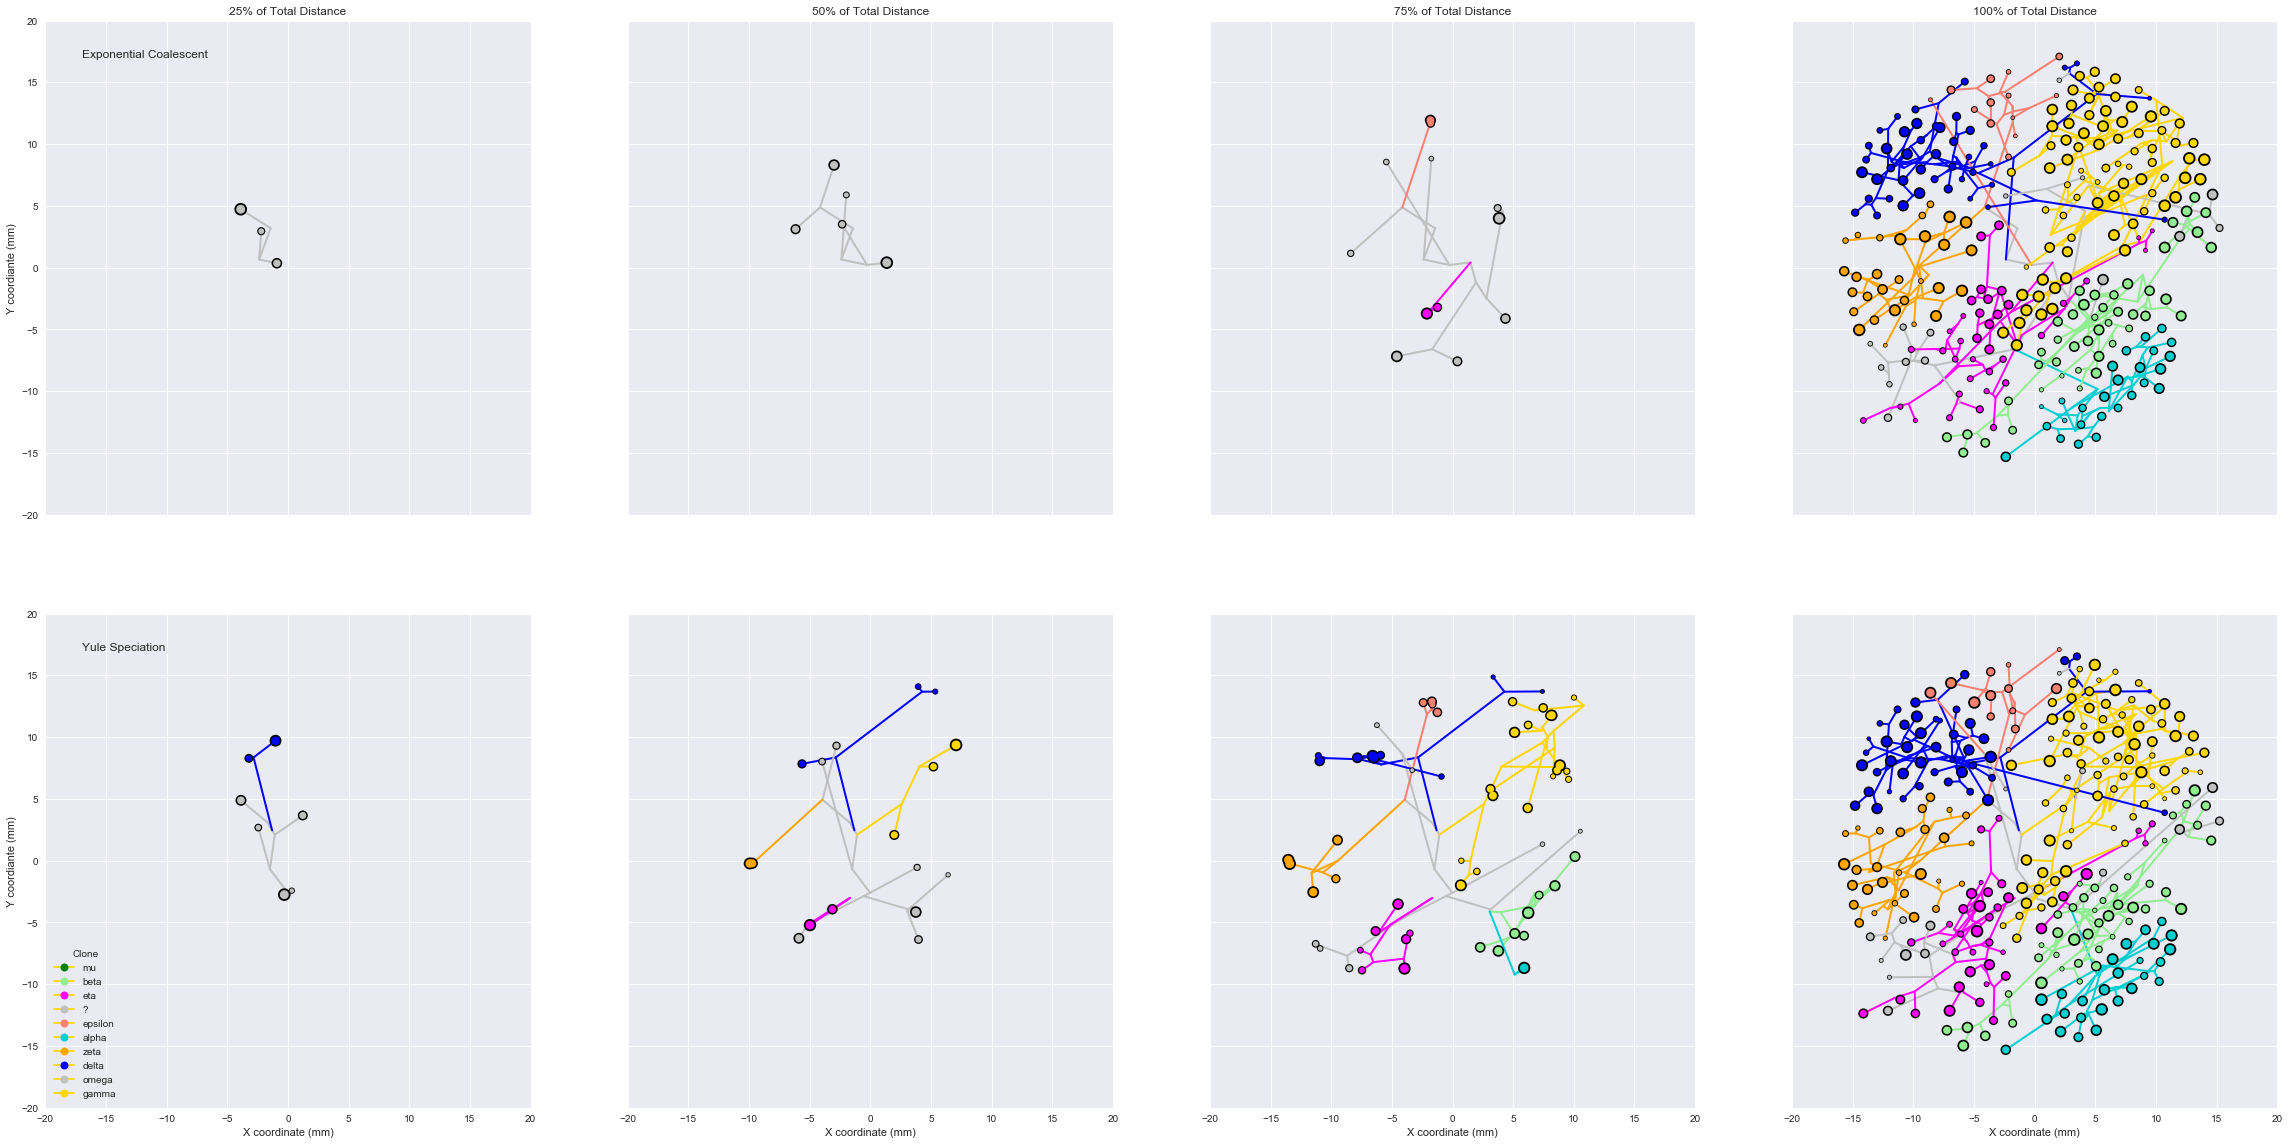

In [43]:
timep = ['25%', '50%', '75%','100%']
fig,ax = plt.subplots(2,4,figsize=(40,20),sharex='col', sharey='row')
for i in range(len(trees)):
    ttree = calc_LBI(trees[i],tau = trees[i].treeHeight * 0.05)
    times = [trees[i].treeHeight * x / 4 for x in range(1,5)]

    for j in range(len(timep)):
        time = times[j]
        stree = timeslice_full(ttree,time,lbi = True)
        rtree = rank_LBI(stree)
        for k in rtree.Objects: ## iterate over objects in tree

            x = k.traits['location1']
            y = k.traits['location2']
            if  k.parent.traits.has_key('location1'):
                xp = k.parent.traits['location1']
            else:
                xp  = x
            if  k.parent.traits.has_key('location2'):
                yp = k.parent.traits['location2']
            else:
                yp = y

            if x==None: ## matplotlib won't plot Nones, like root
                x=0.0
            if xp==None:
                xp=x

            if k.traits['clone'] != 'nan':
                c = colors[k.traits['clone']]
            else: c = 'silver' 

            if k.branchType=='leaf': ## if leaf...
                s=70 ## tip size can be fixed
                s = s * k.rank + 10

                ax[i,j].scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
                ax[i,j].scatter(x,y,s=s*2,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

            ax[i,j].plot([xp,x],[yp,y],lw=branchWidth, color=c ,ls='-',zorder=9)


        ax[1,j].set_xlabel('X coordinate (mm)')
        ax[i,0].set_ylabel('Y coordiante (mm)')
        ax[i,j].set_xlim(-20,20)
        ax[i,j].set_ylim(-20,20)
        ax[0,j].set_title('%s of Total Distance' % timep[j])
han_list = []

for key in colors:
    marker = mlines.Line2D(range(1), range(1), color = c, marker='o', markerfacecolor = colors[key], label = key, markeredgecolor='k',markersize = 8)
    han_list.append(marker)

ax[1,0].legend(handles = han_list, markerfirst = True, title = 'Clone', loc='lower left')
ax[0,0].text(-17,17,'Exponential Coalescent', size = 12)
ax[1,0].text(-17,17,'Yule Speciation',size = 12)



plt.savefig('figures/expcol_yule_lbi_rank.png')

plt.show()


## Comparision of spatial location and LBI rank

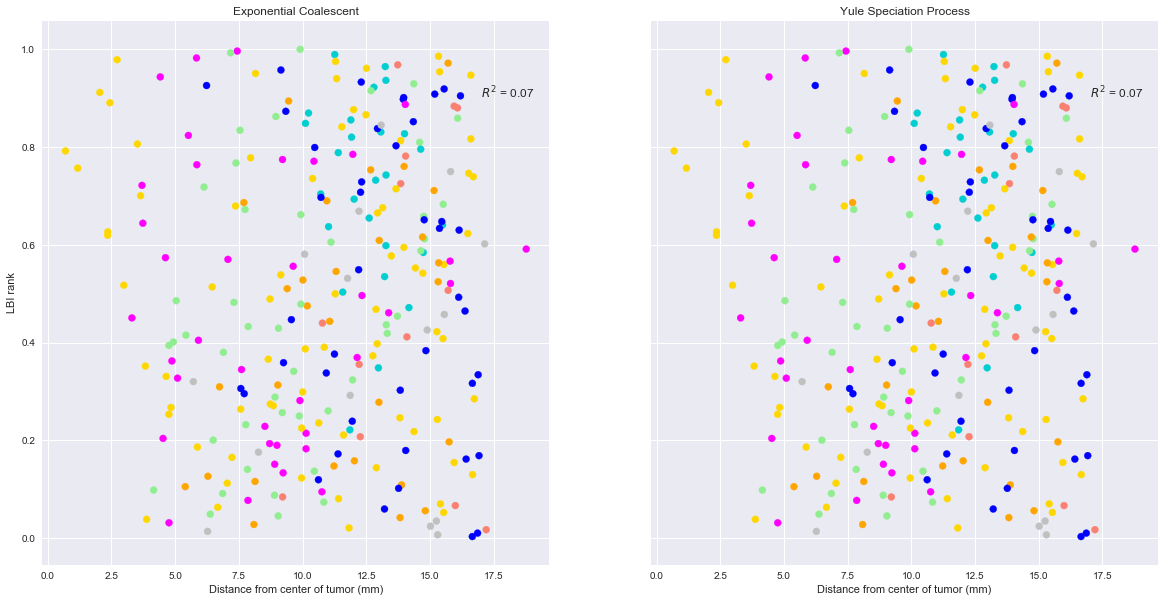

In [44]:
x1 = 0 #will be comparing distances from origin (0,0) since coordinates are normalized to center of final tumor
y1 = 0
fig,ax = plt.subplots(1,2,figsize=(20,10),sharey = 'row')
for i in range(len(trees)):
    ttree = calc_LBI(trees[i],tau = trees[i].treeHeight * 0.05)
    rtree = rank_LBI(stree)
    distance_vector = []
    rank_vector = []
    color_vector = []
    for k in rtree.leaves:
        x2 = k.traits['location1']
        y2 = k.traits['location2']
        dist = math.hypot(x2 - x1, y2 - y1) #used to compute distance between paris of x,y coordinates
        c = colors[k.traits['clone']]
        color_vector.append(c)
        distance_vector.append(dist)
        rank_vector.append(k.rank)
    ax[i].scatter(distance_vector,rank_vector,color = color_vector)
    ax[i].set_title('%s'%titles[i])
    
    rsquared = np.corrcoef(distance_vector,rank_vector)[1,0] #calculate correlation coefficient of two variables
    ax[i].text(17,0.9,"$R^2$ = %.2f"%rsquared,fontsize = 12)
    ax[i].set_xlabel("Distance from center of tumor (mm)")

ax[0].set_ylabel("LBI rank")
plt.savefig('figures/expcol_yule_lbi_rank_scatter.png')
    


## Pairwise comparison of genetic and spatial distance

In [63]:
fig,ax = plt.subplots(1,2,figsize=(20,20))
for t in range(len(trees)):
    spatial_vector = []
    genetic_vector = []
    for node in trees[t].nodes:
        assert len(node.children) <= 2
        if len(node.children)  == 1:
            break
        nonleaf1 = isinstance(node.children[0],bt.node)
        nonleaf2 = isinstance(node.children[1],bt.node)
        if nonleaf1 and nonleaf2:
            for index1 in [x for x in node.children[0].leaves]:
                for index2 in [x for x in node.children[1].leaves]:
                    leaf1 = [x for x in trees[t].leaves if x.numName == index1][0]
                    leaf2 = [x for x in trees[t].leaves if x.numName == index2][0]
                    x1 = leaf1.traits['location1']
                    x2 = leaf2.traits['location1']
                    y1 = leaf1.traits['location2']
                    y2 = leaf2.traits['location2']
                    dist = math.hypot(x2 - x1, y2 - y1)
                    spatial_vector.append(dist)
                    genetic = (leaf1.height - node.height) + (leaf2.height - node.height)
                    genetic_vector.append(genetic)
        
    
        elif nonleaf1:
            for index1 in [x for x in node.children[0].leaves]:
                    leaf1 = [x for x in trees[t].leaves if x.numName == index1][0]
                    leaf2 = node.children[1]
                    x1 = leaf1.traits['location1']
                    x2 = leaf2.traits['location1']
                    y1 = leaf1.traits['location2']
                    y2 = leaf2.traits['location2']
                    dist = math.hypot(x2 - x1, y2 - y1)
                    spatial_vector.append(dist)
                    genetic = (leaf1.height - node.height) + (leaf2.height - node.height)
                    genetic_vector.append(genetic)

                    
        elif nonleaf2:
            for index2 in [x for x in node.children[1].leaves]:
                    leaf1 = node.children[0]
                    leaf2 = [x for x in trees[t].leaves if x.numName == index2][0]
                    x1 = leaf1.traits['location1']
                    x2 = leaf2.traits['location1']
                    y1 = leaf1.traits['location2']
                    y2 = leaf2.traits['location2']
                    dist = math.hypot(x2 - x1, y2 - y1)
                    spatial_vector.append(dist)
                    genetic = (leaf1.height - node.height) + (leaf2.height - node.height)
                    genetic_vector.append(genetic)
        else:
            leaf1 = node.children[0]
            leaf2 = node.children[1]
            x1 = leaf1.traits['location1']
            x2 = leaf2.traits['location1']
            y1 = leaf1.traits['location2']
            y2 = leaf2.traits['location2']
            dist = math.hypot(x2 - x1, y2 - y1)
            spatial_vector.append(dist)
            genetic = (leaf1.height - node.height) + (leaf2.height - node.height)
            genetic_vector.append(genetic)
    
    
#     genetic_vector = [log(y,10) for y in genetic_vector]        
    ax[t].scatter(spatial_vector,genetic_vector)
    ax[0].set_ylabel("log(Pairwise Genetic Distance)")
    ax[t].set_title("%s"%titles[t])
    
    rsquared = np.corrcoef(spatial_vector,genetic_vector)[1,0] #calculate correlation coefficient of two variables
    ax[t].text(25,0.03,"$R^2$ = %.2f"%rsquared,fontsize = 12)
    ax[t].set_xlabel("Distance from center of tumor (mm)")
    

plt.savefig('figures/expcol_yule_genetic_spatial_scatter.png')
    
            
                
        

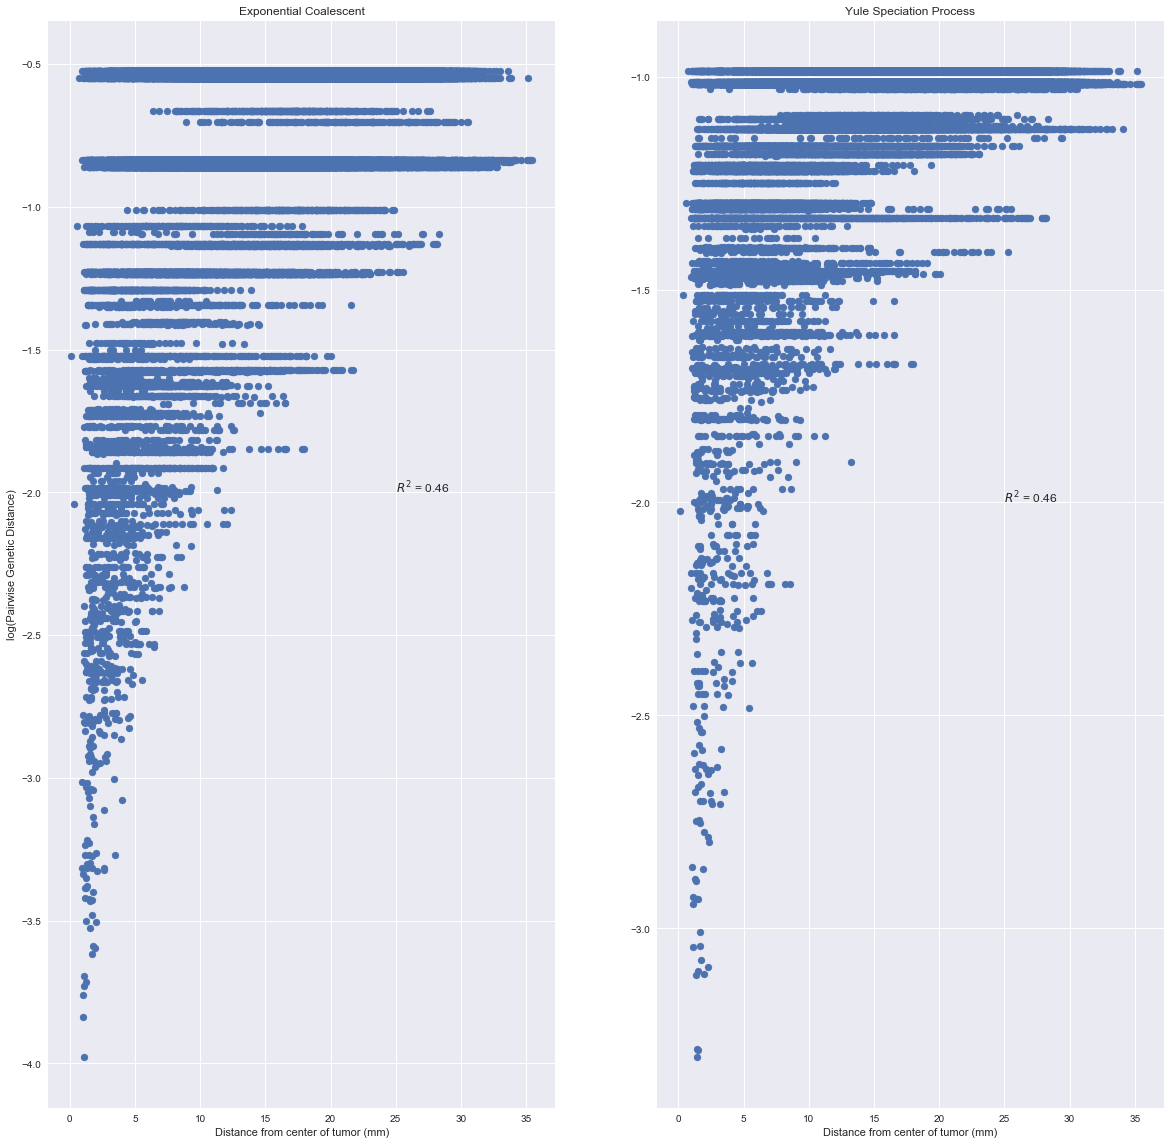

In [64]:
fig,ax = plt.subplots(1,2,figsize=(20,20))
for t in range(len(trees)):
    spatial_vector = []
    genetic_vector = []
    for node in trees[t].nodes:
        assert len(node.children) <= 2
        if len(node.children)  == 1:
            break
        nonleaf1 = isinstance(node.children[0],bt.node)
        nonleaf2 = isinstance(node.children[1],bt.node)
        if nonleaf1 and nonleaf2:
            for index1 in [x for x in node.children[0].leaves]:
                for index2 in [x for x in node.children[1].leaves]:
                    leaf1 = [x for x in trees[t].leaves if x.numName == index1][0]
                    leaf2 = [x for x in trees[t].leaves if x.numName == index2][0]
                    x1 = leaf1.traits['location1']
                    x2 = leaf2.traits['location1']
                    y1 = leaf1.traits['location2']
                    y2 = leaf2.traits['location2']
                    dist = math.hypot(x2 - x1, y2 - y1)
                    spatial_vector.append(dist)
                    genetic = (leaf1.height - node.height) + (leaf2.height - node.height)
                    genetic_vector.append(genetic)
        
    
        elif nonleaf1:
            for index1 in [x for x in node.children[0].leaves]:
                    leaf1 = [x for x in trees[t].leaves if x.numName == index1][0]
                    leaf2 = node.children[1]
                    x1 = leaf1.traits['location1']
                    x2 = leaf2.traits['location1']
                    y1 = leaf1.traits['location2']
                    y2 = leaf2.traits['location2']
                    dist = math.hypot(x2 - x1, y2 - y1)
                    spatial_vector.append(dist)
                    genetic = (leaf1.height - node.height) + (leaf2.height - node.height)
                    genetic_vector.append(genetic)

                    
        elif nonleaf2:
            for index2 in [x for x in node.children[1].leaves]:
                    leaf1 = node.children[0]
                    leaf2 = [x for x in trees[t].leaves if x.numName == index2][0]
                    x1 = leaf1.traits['location1']
                    x2 = leaf2.traits['location1']
                    y1 = leaf1.traits['location2']
                    y2 = leaf2.traits['location2']
                    dist = math.hypot(x2 - x1, y2 - y1)
                    spatial_vector.append(dist)
                    genetic = (leaf1.height - node.height) + (leaf2.height - node.height)
                    genetic_vector.append(genetic)
        else:
            leaf1 = node.children[0]
            leaf2 = node.children[1]
            x1 = leaf1.traits['location1']
            x2 = leaf2.traits['location1']
            y1 = leaf1.traits['location2']
            y2 = leaf2.traits['location2']
            dist = math.hypot(x2 - x1, y2 - y1)
            spatial_vector.append(dist)
            genetic = (leaf1.height - node.height) + (leaf2.height - node.height)
            genetic_vector.append(genetic)
    
    
    genetic_vector = [log(y,10) for y in genetic_vector]        
    ax[t].scatter(spatial_vector,genetic_vector)
    ax[0].set_ylabel("log(Pairwise Genetic Distance)")
    ax[t].set_title("%s"%titles[t])
    
    rsquared = np.corrcoef(spatial_vector,genetic_vector)[1,0] #calculate correlation coefficient of two variables
    ax[t].text(25,-2,"$R^2$ = %.2f"%rsquared,fontsize = 12)
    ax[t].set_xlabel("Distance from center of tumor (mm)")
    

plt.savefig('figures/expcol_yule_genetic_spatial_scatterlog.png')
    
            
                
        

## KDE plots of spatial timeslice

In [151]:
run samogitia.py -b 10000000 -t yule_spatial_dash_MLE.trees -a tslice -ti 0.25 -j 10 -nc -o samogitia_yule_25.out.txt

[==============================]   99%  trees:  9990  elapsed:  0.79m  ETA:  0.00h (4.8e-03 s/tree)
Done!


In [152]:
run samogitia.py -b 10000000 -t yule_spatial_dash_MLE.trees -a tslice -ti 0.50 -j 10 -nc -o samogitia_yule_50.out.txt

[==============================]   99%  trees:  9990  elapsed:  0.67m  ETA:  0.00h (4.0e-03 s/tree)
Done!


In [153]:
run samogitia.py -b 10000000 -t yule_spatial_dash_MLE.trees -a tslice -ti 0.75 -j 10 -nc -o samogitia_yule_75.out.txt

[==============================]   99%  trees:  9990  elapsed:  0.68m  ETA:  0.00h (4.1e-03 s/tree)
Done!


In [154]:
run samogitia.py -b 10000000 -t expcol_spatial_dash_MLE.trees -a tslice -ti 0.25 -j 10 -nc -o samogitia_expcol_25.out.txt

[============================  ]   93%  trees:  9324  elapsed:  5.50m  ETA:  0.01h (3.5e-02 s/tree)

KeyboardInterrupt: 

In [159]:
run samogitia.py -b 10000000 -t yule_spatial_dash_MLE.trees -a tslice -ti 0.99 -j 100 -nc -o samogitia_yule_100.out.txt

[==============================]   99%  trees:  9990  elapsed:  0.73m  ETA:  0.00h (4.4e-03 s/tree)
Done!


In [160]:
run samogitia.py -b 10000000 -t yule_spatial_dash_MLE.trees -a tslice -ti 0.5 -j 100 -nc -o samogitia_expcol_50.out.txt

[==============================]   99%  trees:  9990  elapsed:  0.68m  ETA:  0.00h (4.1e-03 s/tree)
Done!


In [161]:
run samogitia.py -b 10000000 -t yule_spatial_dash_MLE.trees -a tslice -ti 0.75 -j 100 -nc -o samogitia_expcol_75.out.txt

[==============================]   99%  trees:  9990  elapsed:  0.69m  ETA:  0.00h (4.1e-03 s/tree)
Done!


In [162]:
run samogitia.py -b 10000000 -t yule_spatial_dash_MLE.trees -a tslice -ti 0.99 -j 100 -nc -o samogitia_expcol_100.out.txt

[==============================]   99%  trees:  9990  elapsed:  0.69m  ETA:  0.00h (4.2e-03 s/tree)
Done!


In [179]:
##script to estimate KDE of each clone at each time slice
Zlist = [] #list to store dictionaries of KDEs
Zmin_list = []
Zmax_list = []
Plist = [] #list to store dictionaries of populations sizes of KDE
Pmax_list = []#list to store max population at each time point

a = -20
b = 20
N = 100
c = -20
d = 20
outfiles = ['samogitia_yule_25.out.txt', 'samogitia_yule_50.out.txt','samogitia_yule_75.out.txt','samogitia_yule_100.out.txt']
x=np.linspace(a,b,N)
y=np.linspace(c,d,N) 
X,Y=np.meshgrid(x,y) 
positions = np.vstack([Y.ravel(), X.ravel()]) 
for i in range(4):
    treesData = pd.read_csv(outfiles[i], sep = '\t')
    Zdict = {} #dictionary to store Z values of each clone
    Pdict = {} #dictionary to keep track of population sizes in each KDE
    Zmin = 100000000000
    Zmax = 0
    Pmax = 0
    n = len(treesData.columns)
    scotts_factor = n**(-1./(2+4)) #Scott's factor used to estimate bandwidth for KDE if controlling bandwidth
    bw = scotts_factor
    for key in colors:
        trees_clone = treesData[treesData['sliceg'] == key]
        if len(trees_clone) > 10:
            xval = trees_clone['tsliceX'].values
            yval = trees_clone['tsliceY'].values
            x=np.linspace(a,b,N)
            y=np.linspace(c,d,N) 
            X,Y=np.meshgrid(x,y) 
            positions = np.vstack([X.ravel(), Y.ravel()]) 
            values = np.vstack([xval, yval]) 
#             kernel = scipy.stats.gaussian_kde(values,bw_method = bw) #if controlling bandwidth
            kernel = scipy.stats.gaussian_kde(values) #if using bandwidth customized for each clone population
            Z = np.reshape(kernel(positions).T, X.shape)
            Zmi = Z.min()
            Zma = Z.max()
            if Zmi < Zmin:
                Zmin = Zmi
            if Zma > Zmax:
                Zmax = Zma
            P = len(trees_clone)
            Zdict[key] = Z
            Pdict[key] = P
            if P > Pmax:
                Pmax = P
    Plist.append(Pdict)
    Pmax_list.append(Pmax)
    Zlist.append(Zdict)
    Zmin_list.append(Zmin)
    Zmax_list.append(Zmax)

In [180]:
timep = ['25%', '50%', '75%','100%']
branchWidth = 2.0
s = 30
times = [trees[1].treeHeight * x / 4 for x in range(1,5)]
fig,ax = plt.subplots(2,2,figsize=(15,15),sharex='col', sharey='row')
counter = 0
for i in [0,1]:
    for j in [0,1]:
        treesData = pd.read_csv(outfiles[counter], sep = '\t') #t is 25% of mcc tree
        Pmax = Pmax_list[counter]
        for key in colors:
            if Zlist[counter].has_key(key):
                alpha = max([Plist[counter][key]/Pmax,1])
                c = colors[key]
                Z = Zlist[counter][key]
                par = sns.light_palette(c,as_cmap = True, input = 'xcdc')
#                 ax[i,j].contour(X,Y,Z,10,cmap=par,levels=np.linspace(Zmin_list[counter],Zmax_list[counter],6))
                ax[i,j].contour(X,Y,Z,10,cmap=par,alpha = alpha)
        ax[1,j].set_xlabel('X coordinate (mm)')
        ax[i,0].set_ylabel('Y coordiante (mm)')
        ax[i,j].set_title('%s of Total Distance' % timep[counter])
        
        
        
        time = times[counter]
        newleaves = timeslice(trees[1],time)
        nodslice = []
        for k in trees[1].Objects: ## iterate over objects in tree
            if k.x < time:

                g = k.traits['clone']
                x = k.traits['location1']
                y = k.traits['location2']
                if  k.parent.traits.has_key('location1'):
                    xp = k.parent.traits['location1']
                else:
                    xp  = x
                if  k.parent.traits.has_key('location2'):
                    yp = k.parent.traits['location2']
                else:
                    yp = y

                if x==None: ## matplotlib won't plot Nones, like root
                    x=0.0
                if xp==None:
                    xp=x

                if k.traits.has_key('clone'):
                    c = colors[k.traits['clone']]
                else: 
                    c = 'silver' 

                nn = {'xcoord':x,'ycoord':y,'clone':g,'pxcoord':xp,'pycoord':yp, 'px': k.parent.x,"x":k.x} 
                nodslice.append(nn)

                ax[i,j].plot([xp,x],[yp,y],lw=branchWidth,color=c,ls='-',zorder=9)


        for leaf in newleaves:
            if leaf['x'] == time:
                s = 45
                x = leaf['xcoord']
                y = leaf['ycoord']
                xp = leaf['pxcoord']
                yp = leaf['pycoord']
                if leaf.has_key('clone'):
                    c = colors[leaf['clone']]
                else: 
                    c = 'silver'


                ax[i,j].scatter(x,y,s=s,facecolor = c, edgecolor = 'k',zorder = 10)
                ax[i,j].plot([xp,x],[yp,y], lw=branchWidth,color = c, ls='-',zorder = 9)
                
        counter += 1


han_list = []

for key in colors:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key, markeredgecolor='k',markersize = 8)
    han_list.append(marker)

ax[1,0].legend(handles = han_list, markerfirst = True, title = 'Clone', loc='lower left')
        
        
plt.savefig('figures/yule_kde_contour_MCC.png')
            

In [181]:
timep = ['25%', '50%', '75%','100%']
fig,ax = plt.subplots(2,2,figsize=(15,15),sharex='col', sharey='row')
counter = 0
for i in [0,1]:
    for j in [0,1]:
        treesData = pd.read_csv(outfiles[counter], sep = '\t') #t is 25% of mcc tree
        Pmax = Pmax_list[counter]
        for key in colors:
            if Zlist[counter].has_key(key):
                c = colors[key]
                alpha = max([Plist[counter][key]/Pmax,1])
    
                Z = Zlist[counter][key]
                par = sns.light_palette(c,as_cmap = True, input = 'xcdc')
#                 ax[i,j].contour(X,Y,Z,10,cmap=par,levels=np.linspace(Zmin_list[counter],Zmax_list[counter],10))
                ax[i,j].contour(X,Y,Z,10,cmap=par,alpha = alpha)
        ax[1,j].set_xlabel('X coordinate (mm)')
        ax[i,0].set_ylabel('Y coordiante (mm)')
        ax[i,j].set_title('%s of Total Distance' % timep[counter])

                
        counter += 1


han_list = []

for key in colors:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key, markeredgecolor='k',markersize = 8)
    han_list.append(marker)

ax[1,0].legend(handles = han_list, markerfirst = True, title = 'Clone', loc='lower left')
        
        
plt.savefig('figures/yule_kde_contour.png')
            

In [189]:

Zlist = []
Zmin_list = []
Zmax_list = []

a = -20
b = 20
N = 100
c = -20
d = 20
outfiles = ['samogitia_expcol_25.out.txt', 'samogitia_expcol_50.out.txt','samogitia_expcol_75.out.txt','samogitia_expcol_100.out.txt']
x=np.linspace(a,b,N)
y=np.linspace(c,d,N) 
X,Y=np.meshgrid(x,y) 
positions = np.vstack([Y.ravel(), X.ravel()]) 
for i in range(4):
    treesData = pd.read_csv(outfiles[i], sep = '\t')
    Zdict = {}
    Zmin = 100000000000
    Zmax = 0
    n = len(treesData.columns)
#     scotts_factor = n**(-1./(2+4)) #Scott's factor used to estimate bandwidth for KDE
    for key in colors:
        trees_clone = treesData[treesData['sliceg'] == key]
        if len(trees_clone) > 10:
            xval = trees_clone['tsliceX'].values
            yval = trees_clone['tsliceY'].values
            x=np.linspace(a,b,N)
            y=np.linspace(c,d,N) 
            X,Y=np.meshgrid(x,y) 
            positions = np.vstack([X.ravel(), Y.ravel()]) 
            values = np.vstack([xval, yval]) 
#             kernel = scipy.stats.gaussian_kde(values,bw_method = scotts_factor) 
            kernel = scipy.stats.gaussian_kde(values) 
            Z = np.reshape(kernel(positions).T, X.shape)
            Zmi = Z.min()
            Zma = Z.max()
            if Zmi < Zmin:
                Zmin = Zmi
            if Zma > Zmax:
                Zmax = Zma
            Zdict[key] = Z
    Zlist.append(Zdict)
    Zmin_list.append(Zmin)
    Zmax_list.append(Zmax)

C:\Users\mlewinso\AppData\Local\Continuum\Anaconda2\lib\site-packages\scipy\stats\kde.py:514: RuntimeWarning: invalid value encountered in sqrt
  self._norm_factor = sqrt(linalg.det(2*pi*self.covariance)) * self.n
C:\Users\mlewinso\AppData\Local\Continuum\Anaconda2\lib\site-packages\scipy\stats\kde.py:215: RuntimeWarning: overflow encountered in exp
  result = result + exp(-energy)


C:\Users\mlewinso\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\contour.py:1514: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\mlewinso\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\contour.py:1515: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\Users\mlewinso\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\contour.py:1153: RuntimeWarning: invalid value encountered in greater
  return lev[(lev > zmin) & (lev < zmax)]
C:\Users\mlewinso\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\contour.py:1153: RuntimeWarning: invalid value encountered in less
  return lev[(lev > zmin) & (lev < zmax)]


ValueError: zero-size array to reduction operation minimum which has no identity

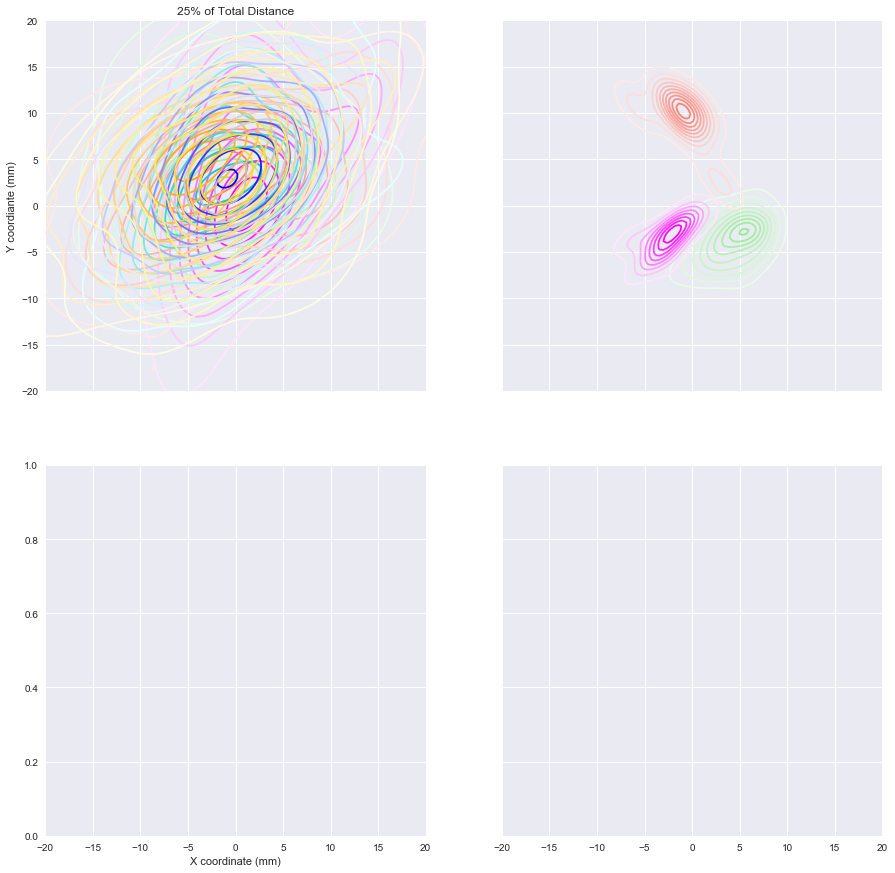

In [190]:
timep = ['25%', '50%', '75%','100%']
fig,ax = plt.subplots(2,2,figsize=(15,15),sharex='col', sharey='row')
counter = 0
for i in [0,1]:
    for j in [0,1]:
        treesData = pd.read_csv(outfiles[counter], sep = '\t') #t is 25% of mcc tree
        for key in colors:
            if Zlist[counter].has_key(key):
                c = colors[key]
    
                Z = Zlist[counter][key]
                par = sns.light_palette(c,as_cmap = True, input = 'xcdc')
#                 ax[i,j].contour(X,Y,Z,10,cmap=par,levels=np.linspace(Zmin_list[counter],Zmax_list[counter],10))
                ax[i,j].contour(X,Y,Z,10,cmap=par)
        ax[1,j].set_xlabel('X coordinate (mm)')
        ax[i,0].set_ylabel('Y coordiante (mm)')
        ax[i,j].set_title('%s of Total Distance' % timep[counter])
        counter += 1
        
plt.savefig('figures/expcol_kde_contour.png')
            

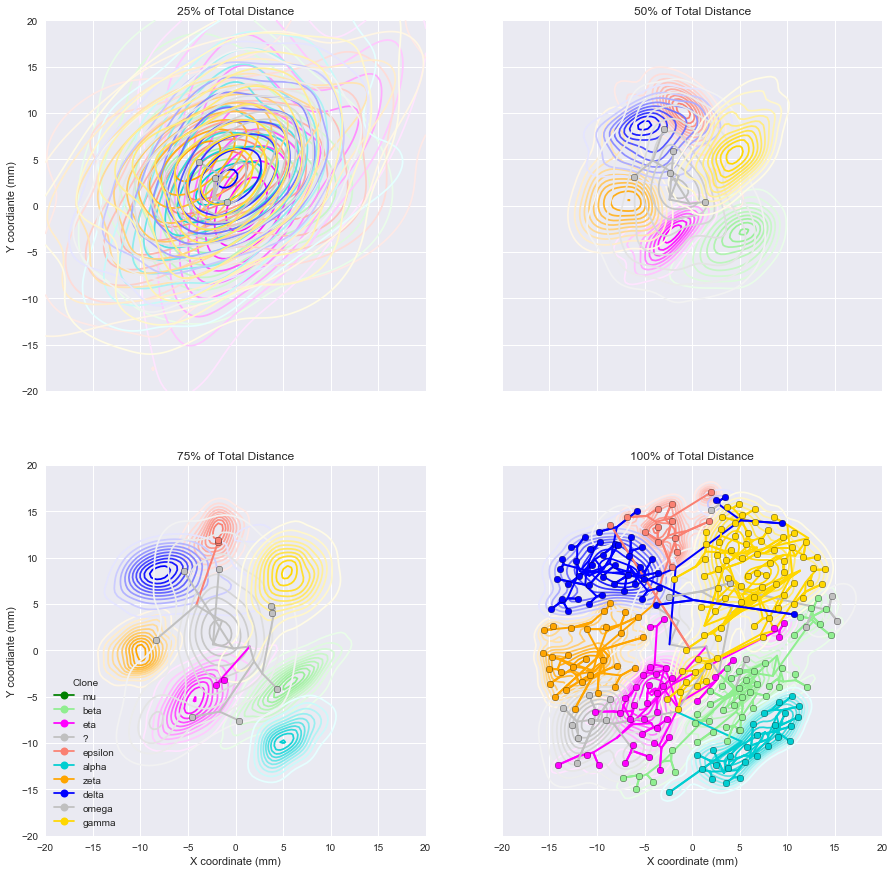

In [165]:
timep = ['25%', '50%', '75%','100%']
branchWidth = 2.0
s = 30
times = [trees[0].treeHeight * x / 4 for x in range(1,5)]
fig,ax = plt.subplots(2,2,figsize=(15,15),sharex='col', sharey='row')
counter = 0
for i in [0,1]:
    for j in [0,1]:
        treesData = pd.read_csv(outfiles[counter], sep = '\t') #t is 25% of mcc tree
        for key in colors:
            if Zlist[counter].has_key(key):
                c = colors[key]
    
                Z = Zlist[counter][key]
                par = sns.light_palette(c,as_cmap = True, input = 'xcdc')
#                 ax[i,j].contour(X,Y,Z,10,cmap=par,levels=np.linspace(Zmin_list[counter],Zmax_list[counter],10))
                ax[i,j].contour(X,Y,Z,10,cmap=par)
        ax[1,j].set_xlabel('X coordinate (mm)')
        ax[i,0].set_ylabel('Y coordiante (mm)')
        ax[i,j].set_title('%s of Total Distance' % timep[counter])
        
        
        
        time = times[counter]
        newleaves = timeslice(trees[0],time)
        nodslice = []
        for k in trees[0].Objects: ## iterate over objects in tree
            if k.x < time:

                g = k.traits['clone']
                x = k.traits['location1']
                y = k.traits['location2']
                if  k.parent.traits.has_key('location1'):
                    xp = k.parent.traits['location1']
                else:
                    xp  = x
                if  k.parent.traits.has_key('location2'):
                    yp = k.parent.traits['location2']
                else:
                    yp = y

                if x==None: ## matplotlib won't plot Nones, like root
                    x=0.0
                if xp==None:
                    xp=x

                if k.traits.has_key('clone'):
                    c = colors[k.traits['clone']]
                else: 
                    c = 'silver' 

                nn = {'xcoord':x,'ycoord':y,'clone':g,'pxcoord':xp,'pycoord':yp, 'px': k.parent.x,"x":k.x} 
                nodslice.append(nn)

                ax[i,j].plot([xp,x],[yp,y],lw=branchWidth,color=c,ls='-',zorder=9)


        for leaf in newleaves:
            if leaf['x'] == time:
                s = 45
                x = leaf['xcoord']
                y = leaf['ycoord']
                xp = leaf['pxcoord']
                yp = leaf['pycoord']
                if leaf.has_key('clone'):
                    c = colors[leaf['clone']]
                else: 
                    c = 'silver'


                ax[i,j].scatter(x,y,s=s,facecolor = c, edgecolor = 'k',zorder = 10)
                ax[i,j].plot([xp,x],[yp,y], lw=branchWidth,color = c, ls='-',zorder = 9)
                
        counter += 1


han_list = []

for key in colors:
    marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key, markeredgecolor='k',markersize = 8)
    han_list.append(marker)

ax[1,0].legend(handles = han_list, markerfirst = True, title = 'Clone', loc='lower left')
        
        
plt.savefig('figures/expcol_kde_contour_MCC.png')
            